In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1083815692351787896
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7498564199
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3789333579163266912
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [5]:
tf.test.is_gpu_available()

True

# Testing a simple neural network

## NN on FL data

First we'll train the network with the FL dataset which contains 700 examples, each made of 16000 samples from the audio file, of 35 semitones (C#3 to B5) from different synthesized pianos. The network should classify the input into one of 35 classes. Below is one of the audio files.

In [60]:
ipd.Audio("../Samples/Piano/FL/PN_ab-ba_piano.mp3")

In [61]:
data = pd.read_csv("../Data/Piano/data_note.tsv", sep="\t", header=0)

In [62]:
data.head()

x0        x1        x2        x3        x4        x5        x6  \
0  0.001465  0.001681  0.005331 -0.002838 -0.015286 -0.009736  0.015490   
1 -0.008995 -0.013210 -0.014460 -0.016820 -0.016346 -0.013873 -0.015907   
2 -0.009459 -0.008396 -0.008832 -0.012935 -0.010718 -0.002320 -0.002686   
3  0.009730  0.016409  0.019472  0.015838  0.014779  0.016792  0.015904   
4 -0.016608 -0.018866 -0.018244 -0.014823 -0.010421 -0.010667 -0.005970   

         x7        x8        x9  ...    x15992    x15993    x15994    x15995  \
0  0.010337  0.001405  0.002371  ...  0.003488  0.001495 -0.001752 -0.002831   
1 -0.014268 -0.007894 -0.003954  ... -0.021490 -0.023198 -0.019781 -0.015293   
2 -0.000303  0.002634  0.000839  ... -0.001041 -0.000368  0.002192  0.005376   
3  0.019331  0.021950  0.020994  ... -0.009846 -0.014612 -0.016278 -0.014461   
4 -0.000487 -0.005703 -0.009161  ... -0.017786 -0.018655 -0.018373 -0.018204   

     x15996    x15997    x15998    x15999  Note           Piano  
0 -0.002337 -0.002936 -0.005293 -0.007221   C#3  PN_ab-ba_piano  
1 -0.012494 -0.012988 -0.014049 -0.012630    D3  PN_ab-ba_piano  
2  0.007840  0.006027  0.003115  0.003368   D#3  PN_ab-ba_piano  
3 -0.012089 -0.009292 -0.008961 -0.012282    E3  PN_ab-ba_piano  
4 -0.018803 -0.017219 -0.015150 -0.011934    F3  PN_ab-ba_piano  

[5 rows x 16002 columns]

In [63]:
data.shape

(665, 16002)

y has to be an integer starting at 0 for the first class, so I convert the notes to MIDI (which is an integer) and subtract 49 so the lowest note is assigned the value of 0.

In [64]:
data["Note"] = librosa.note_to_midi(data["Note"]) - 49

In [65]:
data["Note"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int64)

In [3]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [67]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

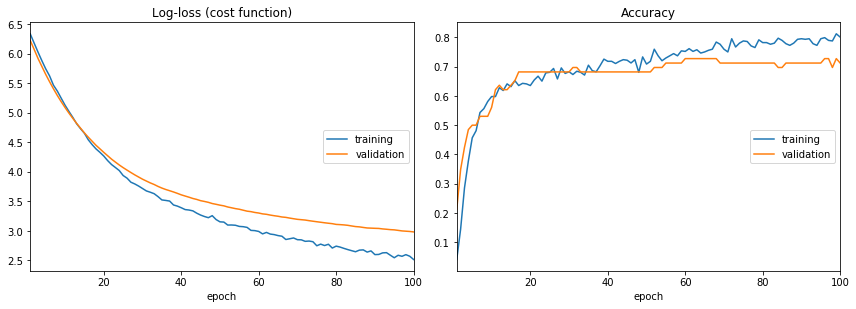

Log-loss (cost function):
training   (min:    2.516, max:    6.334, cur:    2.516)
validation (min:    2.983, max:    6.222, cur:    2.983)

Accuracy:
training   (min:    0.041, max:    0.812, cur:    0.801)
validation (min:    0.212, max:    0.727, cur:    0.712)
Train score: 2.270000732034669
Train accuracy: 0.8890977434645918
Validation score: 2.982716921604041
Validation accuracy: 0.7121212121212122


In [101]:
inputs = Input(shape=(16000,))
hidden1 = Dense(128, kernel_regularizer=l1(0.0001))(inputs)
hidden1_drop = Dropout(0.4)(hidden1)
hidden2 = Dense(64, kernel_regularizer=l2(0.01), activation="relu")(hidden1_drop)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

Works significantly better than previous models.

Quite curiously, in most of the misclassified examples the network has predicted the correct semitone but it has assigned it a wrong octave (12 semitones above or below the actual semitone). This will be addressed later.

In [112]:
predictions

array([[1.6416639e-02, 2.3188660e-02, 1.8524667e-02, ..., 2.7127288e-02,
        3.2727912e-02, 3.7881307e-02],
       [2.1616410e-02, 4.3827046e-02, 4.3205641e-02, ..., 4.8482805e-02,
        3.4212232e-02, 5.8079744e-03],
       [8.3637773e-04, 1.7916888e-04, 1.0837889e-05, ..., 3.2043766e-04,
        5.0121438e-05, 1.6639789e-04],
       ...,
       [1.8445669e-02, 2.4311950e-02, 2.6101582e-02, ..., 2.5564289e-02,
        3.3119250e-02, 1.9127902e-02],
       [9.7179390e-04, 1.3145593e-03, 7.5084594e-04, ..., 9.7634513e-03,
        2.9296656e-03, 1.0386784e-04],
       [2.6753331e-02, 4.1410318e-03, 1.6469661e-02, ..., 3.1870056e-02,
        1.6967606e-02, 2.0866198e-02]], dtype=float32)

In [114]:
predictions = np.argmax(model.predict(X_val), axis=1)
index_misclass = predictions != y_val

for i, j in zip(predictions[index_misclass], y_val[index_misclass]):
    print("{:>8} {:>8}".format(i, j))

      16       28
       4       16
      16       18
       5       29
      28       24
      15       22
      16       28
       8       10
      25       13
      23       11
       6       18
       9       33
      31       21
       5       17
      28       16
       0       12
       7       25
       3        9
       0       12


In [117]:
index_octshift = (abs(predictions - y_val) == 12) | (abs(predictions - y_val) == 24)
for i, j in zip(predictions[index_octshift], y_val[index_octshift]):
    print("{:>8} {:>8}".format(i, j))
print(round(len(predictions[index_octshift])/len(predictions[index_misclass])*100), 
          "% of the misclassified examples are actually octave misclassifications")

      16       28
       4       16
       5       29
      16       28
      25       13
      23       11
       6       18
       9       33
       5       17
      28       16
       0       12
       0       12
63 % of the misclassified examples are actually octave misclassifications


## Adding the Ivy library

Now I add data from the Ivy piano library and re-train the NN.

In [31]:
data = pd.read_pickle("../Data/Piano/data-FL-Ivy.pkl")

In [32]:
data.shape

(2065, 16002)

In [33]:
data["Note"] = librosa.note_to_midi(data["Note"]) - 49

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

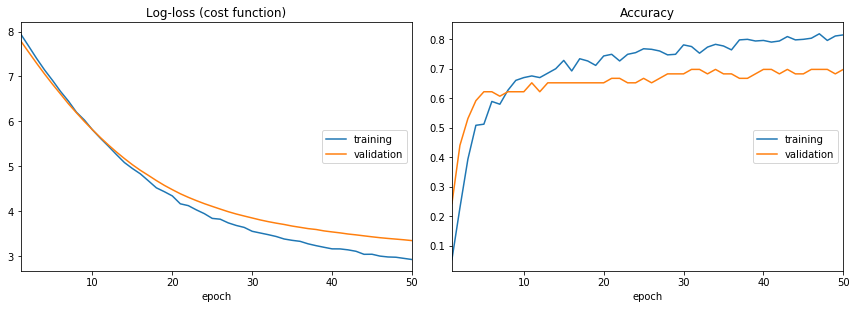

Log-loss (cost function):
training   (min:    2.919, max:    7.950, cur:    2.919)
validation (min:    3.340, max:    7.796, cur:    3.340)

Accuracy:
training   (min:    0.053, max:    0.818, cur:    0.814)
validation (min:    0.242, max:    0.697, cur:    0.697)
Train score: 2.6688355359816014
Train accuracy: 0.9003759389533136
Validation score: 3.340481064536355
Validation accuracy: 0.696969696969697


In [92]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.0001))(inputs)
hidden1_drop = Dropout(0.4)(hidden1)
hidden2 = Dense(64, kernel_regularizer=l1(0.0005), activation="relu")(hidden1_drop)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=50, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

Works well too

## Adding several libraries

Re-training the NN with more piano libraries.

In [124]:
data = pd.read_pickle("../Data/Piano/data-piano-xl.pkl")

In [125]:
data.shape

(3552, 16002)

In [126]:
data = data.reset_index(drop=True)

In [127]:
data["Note"] = librosa.note_to_midi(data["Note"]) - 49

In [128]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

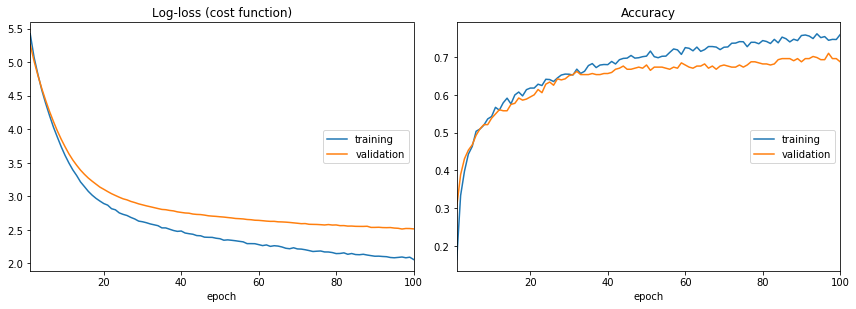

Log-loss (cost function):
training   (min:    2.059, max:    5.423, cur:    2.059)
validation (min:    2.513, max:    5.265, cur:    2.516)

Accuracy:
training   (min:    0.164, max:    0.761, cur:    0.759)
validation (min:    0.304, max:    0.710, cur:    0.687)


In [129]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(64, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

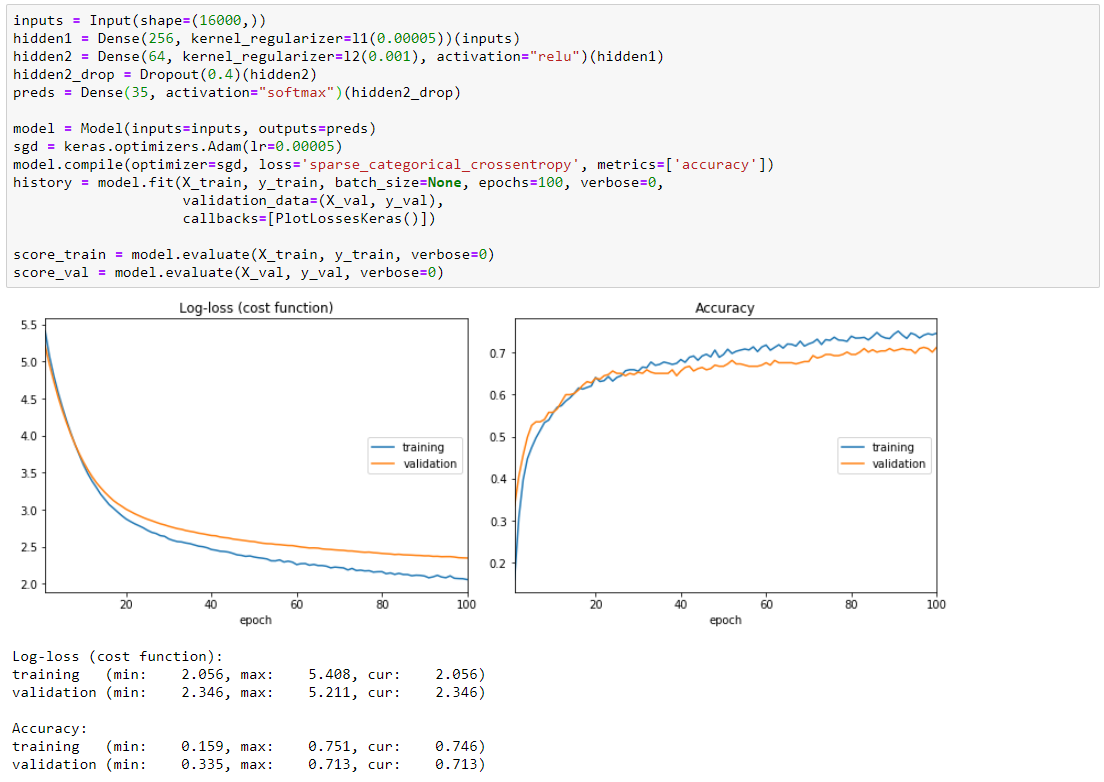

There's still many octave misclassifications.

In [132]:
predictions = np.argmax(model.predict(X_val), axis=1)
index_misclass = predictions != y_val
index_octshift = (abs(predictions - y_val) == 12) | (abs(predictions - y_val) == 24)
print(round(len(predictions[index_octshift])/len(predictions[index_misclass])*100), 
          "% of the misclassified examples are actually octave misclassifications")

63 % of the misclassified examples are actually octave misclassifications


### Removing FL data

Next I repeat the process without using the FL audio samples, since they're the most atypical and different among them.

In [133]:
data.shape

(3552, 16002)

In [134]:
~data["Piano"].str.startswith("PN").values

array([ True,  True,  True, ..., False, False, False])

In [135]:
data = data[~data["Piano"].str.startswith("PN").values]
data.shape

(2887, 16002)

In [136]:
data["Piano"].unique()

array(['Ivy', 'EstateLE', 'City', 'Iowa', 'Kawai', 'Salamander',
       'Baldwin', 'A111-A112', 'Basilica Upright', 'Basilica Grand',
       'Binaural', 'Keppy'], dtype=object)

In [137]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

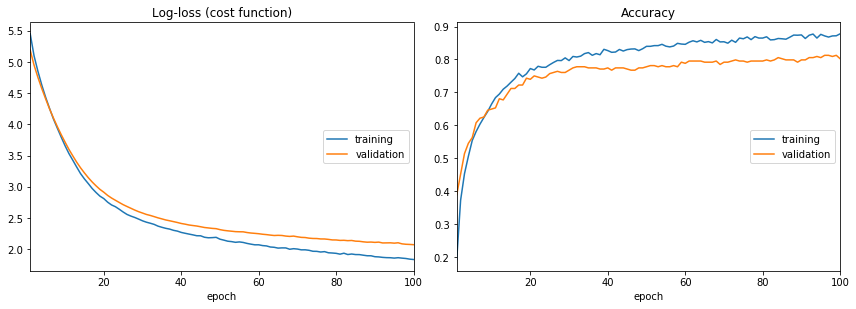

Log-loss (cost function):
training   (min:    1.836, max:    5.450, cur:    1.836)
validation (min:    2.073, max:    5.188, cur:    2.073)

Accuracy:
training   (min:    0.192, max:    0.878, cur:    0.878)
validation (min:    0.389, max:    0.812, cur:    0.802)


In [147]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

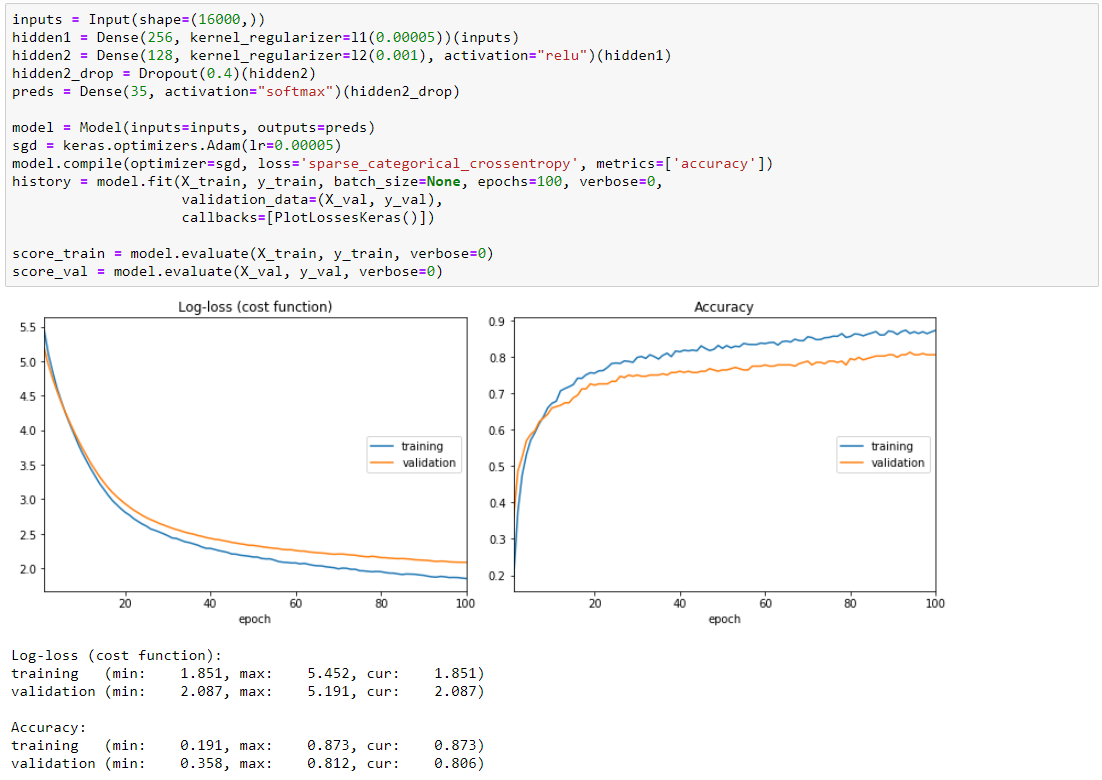

There's an improvement, plus there's less octave confusion

In [148]:
predictions = np.argmax(model.predict(X_val), axis=1)
index_misclass = predictions != y_val
index_octshift = (abs(predictions - y_val) == 12) | (abs(predictions - y_val) == 24)
print(round(len(predictions[index_octshift])/len(predictions[index_misclass])*100), 
          "% of the misclassified examples are actually octave misclassifications")

39 % of the misclassified examples are actually octave misclassifications


### Reducing the number of samples

We can try using 5000 samples of the audio waveform instead of 16000 and see how the NN behaves.

In [149]:
data = pd.read_pickle("../Data/Piano/data-piano-xl.pkl")

In [150]:
data.shape

(3552, 16002)

In [151]:
data = data.drop(["x{}".format(i) for i in range(5000,16000)], axis=1)

In [152]:
data.shape

(3552, 5002)

In [153]:
data["Note"] = librosa.note_to_midi(data["Note"]) - 49

In [154]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

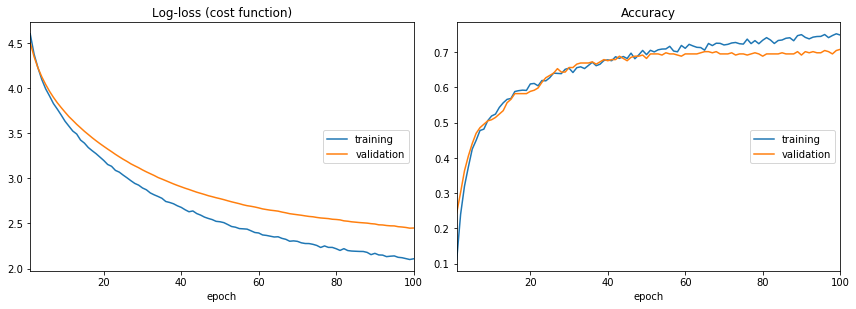

Log-loss (cost function):
training   (min:    2.100, max:    4.603, cur:    2.108)
validation (min:    2.448, max:    4.505, cur:    2.449)

Accuracy:
training   (min:    0.112, max:    0.752, cur:    0.748)
validation (min:    0.244, max:    0.707, cur:    0.707)


In [156]:
inputs = Input(shape=(5000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(64, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

It seems to perform similarly.

### Checking all pianos

Here I test the performance of the NN on each library to see whether any of them is somehow anomalous.

In [4]:
data = pd.read_pickle("../Data/Piano/data-piano-xl.pkl")

In [5]:
data["Note"] = librosa.note_to_midi(data["Note"]) - 49

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

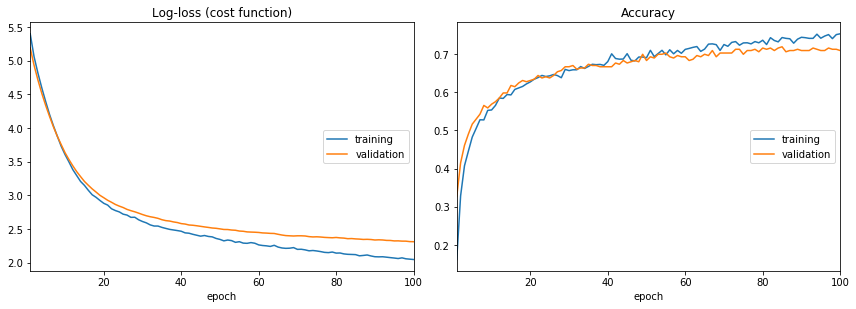

Log-loss (cost function):
training   (min:    2.045, max:    5.398, cur:    2.045)
validation (min:    2.309, max:    5.189, cur:    2.309)

Accuracy:
training   (min:    0.162, max:    0.753, cur:    0.753)
validation (min:    0.327, max:    0.719, cur:    0.709)


In [7]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(64, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

In [8]:
for piano in list(data["Piano"].unique()):
    x = data[data["Piano"] == piano].drop(["Note", "Piano"], axis=1)
    y = data[data["Piano"] == piano][["Note"]]
    loss, acc = model.evaluate(x, y, verbose=0)
    print("{:>25}{:>25}".format(piano, round(acc, 4)))

                      Ivy                   0.6707
                 EstateLE                   0.9279
                     City                   0.9571
                     Iowa                   0.9223
                    Kawai                      1.0
               Salamander                      1.0
                  Baldwin                   0.9881
                A111-A112                   0.9935
         Basilica Upright                    0.982
           Basilica Grand                   0.9835
                 Binaural                   0.7761
                    Keppy                   0.9429
           PN_ab-ba_piano                   0.7429
        PN_arena_ambiance                   0.5429
       PN_ballad_epiano_1                   0.7143
       PN_ballad_epiano_2                   0.8571
       PN_ballad_epiano_3                   0.8857
    PN_ballad_grand_piano                   0.7143
         PN_delayed_piano                   0.9429
             PN_digipiano      

First we'll remove the pianos from the FL subset which perform the worst

In [37]:
data = data[np.array([data["Piano"].values != i for i in ["PN_trancepiano", "PN_terminator", "PN_power_grand", 
                                                          "PN_pop_keys", "PN_piano_crushed", "PN_ballad_grand_piano", 
                                                          "PN_arena_ambiance"]]).all(axis=0)]
data = data[data["Piano"] != "PN_nexus_grandpiano"]
data = data[~data["Piano"].str.startswith("PN_ballad").values]
data.shape

(3167, 16002)

In [38]:
data["Piano"].unique()

array(['Ivy', 'EstateLE', 'City', 'Iowa', 'Kawai', 'Salamander',
       'Baldwin', 'A111-A112', 'Basilica Upright', 'Basilica Grand',
       'Binaural', 'Keppy', 'PN_ab-ba_piano', 'PN_delayed_piano',
       'PN_digipiano', 'PN_heaven', 'PN_ibiza', 'PN_nebula',
       'PN_powerful_bright', 'PN_rocky_piano'], dtype=object)

In [39]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

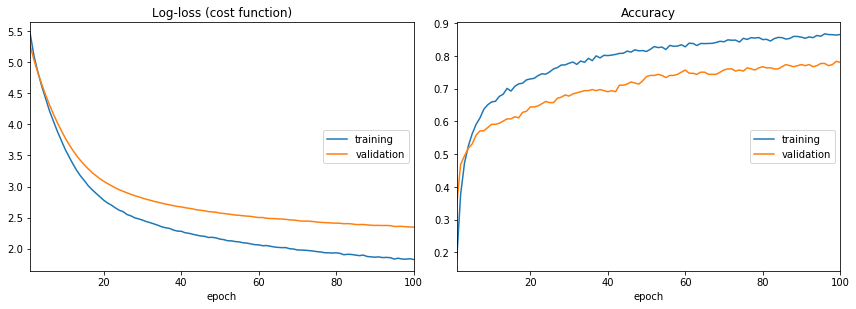

Log-loss (cost function):
training   (min:    1.824, max:    5.461, cur:    1.824)
validation (min:    2.346, max:    5.266, cur:    2.346)

Accuracy:
training   (min:    0.178, max:    0.868, cur:    0.866)
validation (min:    0.346, max:    0.784, cur:    0.781)


In [41]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

In [42]:
for piano in list(data["Piano"].unique()):
    x = data[data["Piano"] == piano].drop(["Note", "Piano"], axis=1)
    y = data[data["Piano"] == piano][["Note"]]
    loss, acc = model.evaluate(x, y, verbose=0)
    print("{:>25}{:>25}".format(piano, round(acc, 4)))

                      Ivy                    0.785
                 EstateLE                    0.982
                     City                   0.9571
                     Iowa                   0.9126
                    Kawai                      1.0
               Salamander                      1.0
                  Baldwin                    0.994
                A111-A112                   0.9968
         Basilica Upright                    0.991
           Basilica Grand                    0.989
                 Binaural                   0.8507
                    Keppy                   0.9143
           PN_ab-ba_piano                   0.5714
         PN_delayed_piano                   0.8286
             PN_digipiano                   0.9714
                PN_heaven                   0.8857
                 PN_ibiza                   0.5429
                PN_nebula                   0.8286
       PN_powerful_bright                   0.8286
           PN_rocky_piano      

In [43]:
data = data[np.array([data["Piano"].values != i for i in ["PN_ab-ba_piano", "PN_ibiza"]]).all(axis=0)]

In [44]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

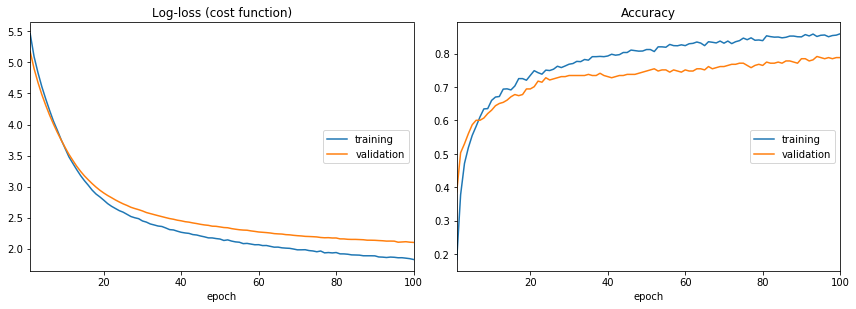

Log-loss (cost function):
training   (min:    1.827, max:    5.460, cur:    1.827)
validation (min:    2.102, max:    5.172, cur:    2.102)

Accuracy:
training   (min:    0.183, max:    0.860, cur:    0.860)
validation (min:    0.386, max:    0.792, cur:    0.789)


In [45]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

In [46]:
for piano in list(data["Piano"].unique()):
    x = data[data["Piano"] == piano].drop(["Note", "Piano"], axis=1)
    y = data[data["Piano"] == piano][["Note"]]
    loss, acc = model.evaluate(x, y, verbose=0)
    print("{:>25}{:>25}".format(piano, round(acc, 4)))

                      Ivy                   0.7614
                 EstateLE                   0.9505
                     City                   0.9714
                     Iowa                   0.9417
                    Kawai                      1.0
               Salamander                      1.0
                  Baldwin                    0.994
                A111-A112                   0.9935
         Basilica Upright                   0.9865
           Basilica Grand                   0.9835
                 Binaural                    0.806
                    Keppy                   0.8857
         PN_delayed_piano                   0.7143
             PN_digipiano                      1.0
                PN_heaven                   0.9714
                PN_nebula                   0.7429
       PN_powerful_bright                   0.9143
           PN_rocky_piano                      1.0


In [47]:
data = data[np.array([data["Piano"].values != i for i in ["PN_delayed_piano", "PN_nebula"]]).all(axis=0)]

In [48]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

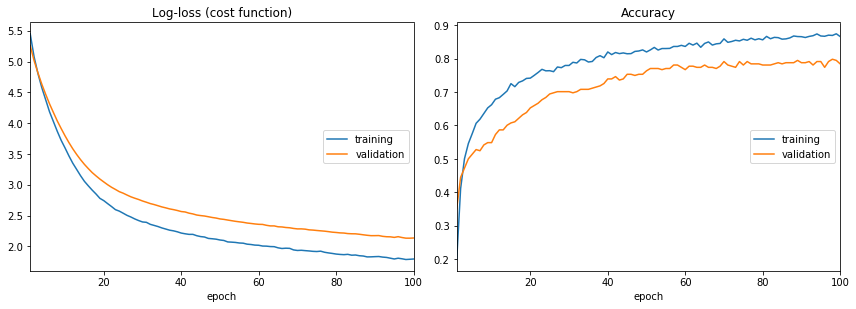

Log-loss (cost function):
training   (min:    1.787, max:    5.450, cur:    1.795)
validation (min:    2.133, max:    5.258, cur:    2.136)

Accuracy:
training   (min:    0.198, max:    0.875, cur:    0.867)
validation (min:    0.351, max:    0.799, cur:    0.785)


In [49]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

In [50]:
for piano in list(data["Piano"].unique()):
    x = data[data["Piano"] == piano].drop(["Note", "Piano"], axis=1)
    y = data[data["Piano"] == piano][["Note"]]
    loss, acc = model.evaluate(x, y, verbose=0)
    print("{:>25}{:>25}".format(piano, round(acc, 4)))

                      Ivy                   0.7714
                 EstateLE                   0.9595
                     City                   0.9786
                     Iowa                   0.9126
                    Kawai                      1.0
               Salamander                      1.0
                  Baldwin                   0.9881
                A111-A112                   0.9935
         Basilica Upright                   0.9955
           Basilica Grand                   0.9945
                 Binaural                   0.8806
                    Keppy                   0.9429
             PN_digipiano                   0.9143
                PN_heaven                   0.8857
       PN_powerful_bright                   0.8857
           PN_rocky_piano                   0.9143


In [59]:
data = data[data["Piano"] != "Binaural"]

In [60]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop("Piano", axis=1), "Note")

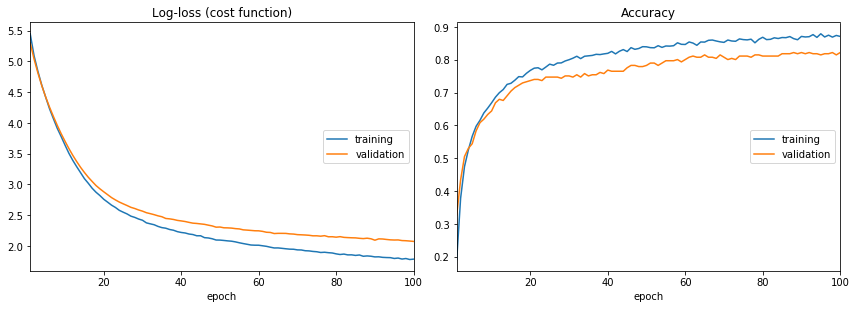

Log-loss (cost function):
training   (min:    1.782, max:    5.448, cur:    1.788)
validation (min:    2.076, max:    5.300, cur:    2.076)

Accuracy:
training   (min:    0.192, max:    0.879, cur:    0.871)
validation (min:    0.327, max:    0.822, cur:    0.822)


In [61]:
inputs = Input(shape=(16000,))
hidden1 = Dense(256, kernel_regularizer=l1(0.00005))(inputs)
hidden2 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(hidden1)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(35, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

In [62]:
for piano in list(data["Piano"].unique()):
    x = data[data["Piano"] == piano].drop(["Note", "Piano"], axis=1)
    y = data[data["Piano"] == piano][["Note"]]
    loss, acc = model.evaluate(x, y, verbose=0)
    print("{:>25}{:>25}".format(piano, round(acc, 4)))

                      Ivy                   0.7921
                 EstateLE                   0.9414
                     City                   0.9643
                     Iowa                   0.9515
                    Kawai                     0.95
               Salamander                     0.95
                  Baldwin                   0.9881
                A111-A112                   0.9968
         Basilica Upright                   0.9865
           Basilica Grand                   0.9835
                    Keppy                   0.9714
             PN_digipiano                      1.0
                PN_heaven                   0.9143
       PN_powerful_bright                   0.9429
           PN_rocky_piano                   0.8857


In [64]:
data.to_pickle("../Data/data-piano-reduced.pkl")

## Saving the model

In [65]:
model.save_weights('NN_weights.h5')

In [66]:
with open('NN_architecture.json', 'w') as f:
    f.write(model.to_json())